<a href="https://colab.research.google.com/github/RodrigoGuedesDP/Games/blob/main/IA_Fundamentals/Practica_2_IA_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problema de Optimización: Vehicle Routing Problem.


Costo de la solución con Hill Climbing: 790.3479328931635
Número de iteraciones de Hill Climbing: 23
Número de evaluaciones de vecinos en Hill Climbing: 644
Tiempo de ejecución de Hill Climbing: 0.1065 segundos
Rutas obtenidas con Hill Climbing:
Vehículo 1 (Capacidad 15): [14, 15, 17, 12, 9]
Vehículo 2 (Capacidad 15): [5, 3, 4, 7]
Vehículo 3 (Capacidad 15): [1, 8, 11, 6, 2, 13]
Vehículo 4 (Capacidad 15): [10, 18, 16, 0, 19]
Vehículo 5 (Capacidad 15): []
Vehículo 6 (Capacidad 15): []
Vehículo 7 (Capacidad 15): []


<ipython-input-1-b2668d32c784>:190: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(routes))


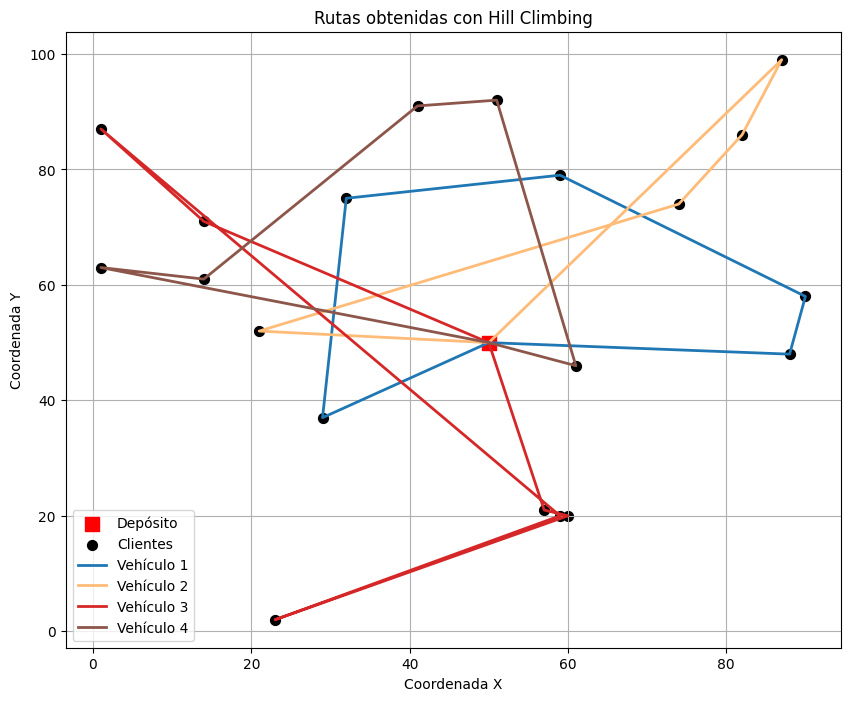


Costo de la solución con Simulated Annealing: 668.2197939189723
Número total de iteraciones de Simulated Annealing: 13500
Número de niveles de temperatura en Simulated Annealing: 135
Tiempo de ejecución de Simulated Annealing: 0.9629 segundos
Rutas obtenidas con Simulated Annealing:
Vehículo 1 (Capacidad 15): []
Vehículo 2 (Capacidad 15): [4, 3, 5, 17]
Vehículo 3 (Capacidad 15): [19]
Vehículo 4 (Capacidad 15): [10, 1, 16, 0]
Vehículo 5 (Capacidad 15): [13, 14, 15, 11, 2, 6, 9]
Vehículo 6 (Capacidad 15): []
Vehículo 7 (Capacidad 15): [7, 18, 8, 12]


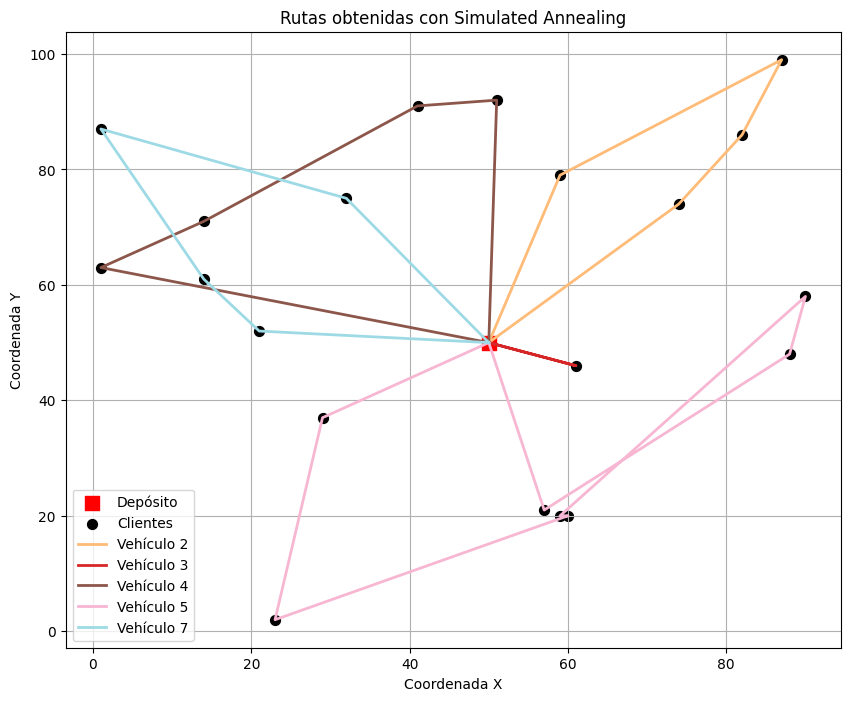

In [1]:
import random
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import time  # Importar el módulo time para medir tiempos de ejecución

# -------------------- Datos del problema --------------------

# Número de clientes
N = 20

# Demanda máxima por cliente
D_max = 5

# Capacidad de los vehículos (todos iguales para simplificar)
C = 15

# Coordenadas del depósito
depot = (50, 50)  # Cambiado a (50, 50)

# Generación de ubicaciones y demandas aleatorias para los clientes
np.random.seed(42)
customer_locations = np.random.randint(0, 100, size=(N, 2))
customer_demands = np.random.randint(1, D_max + 1, size=N)

# Lista de clientes con sus demandas y ubicaciones
customers = [
    {'index': i, 'demand': customer_demands[i], 'location': tuple(customer_locations[i])}
    for i in range(N)
]

# -------------------- Cálculo del número mínimo de vehículos --------------------

# Demanda total máxima posible
total_demand_max = N * D_max

# Número mínimo de vehículos necesarios
num_vehicles = math.ceil((N * D_max) / C)

# Crear la flota de vehículos con capacidades iguales
fleet = [{'vehicle_id': i, 'capacity': C} for i in range(num_vehicles)]

# Verificación de que la capacidad total de la flota es suficiente
total_capacity = sum(vehicle['capacity'] for vehicle in fleet)
if total_capacity < total_demand_max:
    raise ValueError("La capacidad total de la flota es insuficiente para atender la demanda máxima posible.")

# -------------------- Funciones auxiliares --------------------

def distance(a, b):
    """Calcula la distancia euclidiana entre dos puntos."""
    return math.hypot(a[0] - b[0], a[1] - b[1])

def create_initial_solution(customers, fleet):
    """Crea una solución inicial respetando las restricciones de capacidad y número de vehículos."""
    routes = [[] for _ in fleet]
    capacity_remaining = [vehicle['capacity'] for vehicle in fleet]
    unvisited = set(c['index'] for c in customers)
    customer_list = list(unvisited)
    random.shuffle(customer_list)  # Mezclar clientes para asignación aleatoria

    for customer_index in customer_list:
        demand = customers[customer_index]['demand']
        assigned = False
        for idx, vehicle in enumerate(fleet):
            if demand <= capacity_remaining[idx]:
                routes[idx].append(customer_index)
                capacity_remaining[idx] -= demand
                assigned = True
                break
        if not assigned:
            raise ValueError("No es posible asignar al cliente {} sin exceder la capacidad.".format(customer_index))
    return routes

def total_distance(routes, customers, depot):
    """Calcula la distancia total de una solución."""
    total_dist = 0
    for route in routes:
        if route:
            prev_location = depot
            for customer_index in route:
                customer_location = customers[customer_index]['location']
                total_dist += distance(prev_location, customer_location)
                prev_location = customer_location
            total_dist += distance(prev_location, depot)  # Regreso al depósito
    return total_dist

def get_neighbors(solution, customers, fleet):
    """Genera soluciones vecinas moviendo clientes entre rutas."""
    neighbors = []
    num_vehicles = len(fleet)
    for i in range(num_vehicles):
        for j in range(num_vehicles):
            if i != j:
                for a in range(len(solution[i])):
                    # Intentar mover el cliente a de la ruta i a la ruta j
                    new_solution = copy.deepcopy(solution)
                    customer_a = new_solution[i][a]

                    # Verificar restricciones de capacidad
                    demand_a = customers[customer_a]['demand']
                    capacity_i = fleet[i]['capacity']
                    capacity_j = fleet[j]['capacity']

                    route_i_demand = sum(customers[c]['demand'] for c in new_solution[i]) - demand_a
                    route_j_demand = sum(customers[c]['demand'] for c in new_solution[j]) + demand_a

                    if route_i_demand <= capacity_i and route_j_demand <= capacity_j:
                        new_solution[i].pop(a)
                        new_solution[j].append(customer_a)
                        neighbors.append(new_solution)
    return neighbors

def get_random_neighbor(solution, customers, fleet):
    """Genera una solución vecina aleatoria para Simulated Annealing."""
    new_solution = copy.deepcopy(solution)
    num_vehicles = len(fleet)
    i, j = random.sample(range(num_vehicles), 2)
    if solution[i]:
        a = random.randrange(len(solution[i]))
        customer_a = solution[i][a]

        demand_a = customers[customer_a]['demand']
        capacity_i = fleet[i]['capacity']
        capacity_j = fleet[j]['capacity']

        route_i_demand = sum(customers[c]['demand'] for c in solution[i]) - demand_a
        route_j_demand = sum(customers[c]['demand'] for c in solution[j]) + demand_a

        if route_i_demand <= capacity_i and route_j_demand <= capacity_j:
            new_solution[i].pop(a)
            new_solution[j].append(customer_a)
            return new_solution
    return new_solution

# -------------------- Implementación de Hill Climbing --------------------

def hill_climbing(customers, depot, fleet):
    current_solution = create_initial_solution(customers, fleet)
    current_cost = total_distance(current_solution, customers, depot)
    improving = True
    iteration_count = 0  # Contador de iteraciones
    neighbor_evaluations = 0  # Contador de evaluaciones de vecinos
    while improving:
        improving = False
        neighbors = get_neighbors(current_solution, customers, fleet)
        iteration_count += 1
        for neighbor in neighbors:
            neighbor_evaluations += 1
            neighbor_cost = total_distance(neighbor, customers, depot)
            if neighbor_cost < current_cost:
                current_solution = neighbor
                current_cost = neighbor_cost
                improving = True
                break  # Acepta el primer vecino mejor
    return current_solution, current_cost, iteration_count, neighbor_evaluations

# -------------------- Implementación de Simulated Annealing --------------------

def simulated_annealing(customers, depot, fleet, initial_temperature, cooling_rate, iteration_per_temp):
    current_solution = create_initial_solution(customers, fleet)
    current_cost = total_distance(current_solution, customers, depot)
    best_solution = current_solution
    best_cost = current_cost
    T = initial_temperature
    total_iterations = 0  # Contador de iteraciones totales
    temperature_steps = 0  # Contador de niveles de temperatura
    while T > 1:
        temperature_steps += 1
        for _ in range(iteration_per_temp):
            total_iterations += 1
            new_solution = get_random_neighbor(current_solution, customers, fleet)
            new_cost = total_distance(new_solution, customers, depot)
            delta = new_cost - current_cost
            if delta < 0 or random.uniform(0, 1) < math.exp(-delta / T):
                current_solution = new_solution
                current_cost = new_cost
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost
        T *= cooling_rate
    return best_solution, best_cost, total_iterations, temperature_steps

# -------------------- Función para visualizar las rutas --------------------

def plot_routes(routes, customers, depot, title):
    """Visualiza las rutas en un gráfico, asignando un color distinto a cada ruta."""
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab20', len(routes))

    # Dibujar el depósito
    plt.scatter(depot[0], depot[1], c='red', marker='s', s=100, label='Depósito')

    # Dibujar los clientes
    customer_positions = np.array([customer['location'] for customer in customers])
    plt.scatter(customer_positions[:, 0], customer_positions[:, 1], c='black', marker='o', s=50, label='Clientes')

    # Dibujar las rutas
    for idx, route in enumerate(routes):
        if route:
            route_coords = [depot] + [customers[i]['location'] for i in route] + [depot]
            xs, ys = zip(*route_coords)
            plt.plot(xs, ys, color=colors(idx % 20), linewidth=2, label=f'Vehículo {idx + 1}')

    plt.title(title)
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------- Ejecución y resultados --------------------

# Ejecutar Hill Climbing
start_time_hc = time.time()
hc_solution, hc_cost, hc_iterations, hc_neighbor_evals = hill_climbing(customers, depot, fleet)
end_time_hc = time.time()
hc_execution_time = end_time_hc - start_time_hc

print("Costo de la solución con Hill Climbing:", hc_cost)
print("Número de iteraciones de Hill Climbing:", hc_iterations)
print("Número de evaluaciones de vecinos en Hill Climbing:", hc_neighbor_evals)
print("Tiempo de ejecución de Hill Climbing: {:.4f} segundos".format(hc_execution_time))
print("Rutas obtenidas con Hill Climbing:")
for idx, route in enumerate(hc_solution):
    vehicle_capacity = fleet[idx]['capacity']
    print(f"Vehículo {idx + 1} (Capacidad {vehicle_capacity}): {route}")

# Visualizar las rutas obtenidas con Hill Climbing
plot_routes(hc_solution, customers, depot, "Rutas obtenidas con Hill Climbing")

# Ejecutar Simulated Annealing
start_time_sa = time.time()
sa_solution, sa_cost, sa_total_iterations, sa_temperature_steps = simulated_annealing(
    customers,
    depot,
    fleet,
    initial_temperature=1000,
    cooling_rate=0.95,
    iteration_per_temp=100
)
end_time_sa = time.time()
sa_execution_time = end_time_sa - start_time_sa

print("\nCosto de la solución con Simulated Annealing:", sa_cost)
print("Número total de iteraciones de Simulated Annealing:", sa_total_iterations)
print("Número de niveles de temperatura en Simulated Annealing:", sa_temperature_steps)
print("Tiempo de ejecución de Simulated Annealing: {:.4f} segundos".format(sa_execution_time))
print("Rutas obtenidas con Simulated Annealing:")
for idx, route in enumerate(sa_solution):
    vehicle_capacity = fleet[idx]['capacity']
    print(f"Vehículo {idx + 1} (Capacidad {vehicle_capacity}): {route}")

# Visualizar las rutas obtenidas con Simulated Annealing
plot_routes(sa_solution, customers, depot, "Rutas obtenidas con Simulated Annealing")
